## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
from __future__ import print_function
import random, numpy as np
import keras, tensorflow as tf

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape, x_train[444].dtype 

((32, 32, 3), dtype('uint8'))

[9] truck


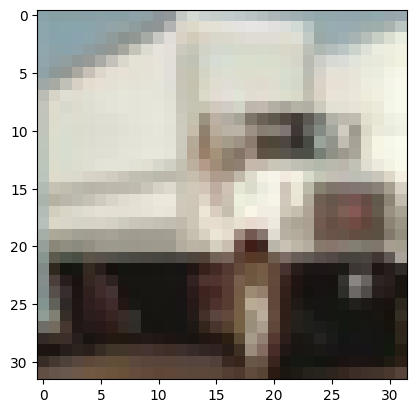

In [8]:
## Let's look at one of the images

image_no = 444
print(y_train[image_no], class_names[y_train[image_no][0]])
plt.imshow(x_train[image_no]);

In [9]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [11]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.

In [12]:
set_seed(12345)

# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 512)               147968    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

We still have 181K parameters, even though this is a "small" model.


In [13]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 19s 10ms/step - loss: 1.6677 - accuracy: 0.3955 - val_loss: 1.4509 - val_accuracy: 0.4886
Epoch 2/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.3627 - accuracy: 0.5112 - val_loss: 1.2541 - val_accuracy: 0.5568
Epoch 3/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.2353 - accuracy: 0.5619 - val_loss: 1.1970 - val_accuracy: 0.5792
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.1569 - accuracy: 0.5915 - val_loss: 1.1711 - val_accuracy: 0.5875
Epoch 5/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.1011 - accuracy: 0.6144 - val_loss: 1.1222 - val_accuracy: 0.6113
Epoch 6/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0600 - accuracy: 0.6281 - val_loss: 1.0678 - val_accuracy: 0.6246
Epoch 7/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0306 - accuracy: 0.6403 - val_loss: 1.0730 - va

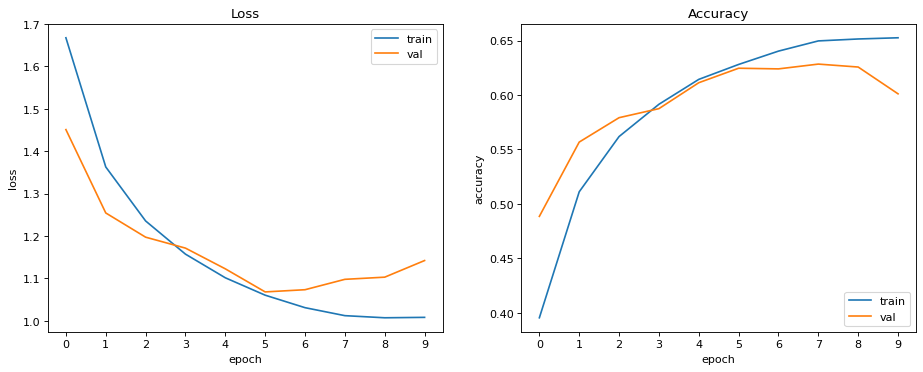

In [14]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

### Model Evaluation

In [15]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 0.986761, Accuracy: 0.647580
 Test Loss: 1.141823, Accuracy: 0.601100

[[683  31  66  18  41  19   5  36 137  34]
 [ 27 731  12  14   5   9   8   8  62 122]
 [ 41   4 343  54  37  50  21  19   9   5]
 [ 22  10  66 377  42 210  26  53  14  16]
 [ 29   5 200 128 627 111  30 147  11  14]
 [  4   2  44  60   8 361   5  44   2   5]
 [ 39  36 189 259 175 177 884  50  25  41]
 [  7   8  34  39  48  43   4 614   4  23]
 [ 94  16  25  21  12  10   7   4 678  27]
 [ 54 157  21  30   5  10  10  25  58 713]]


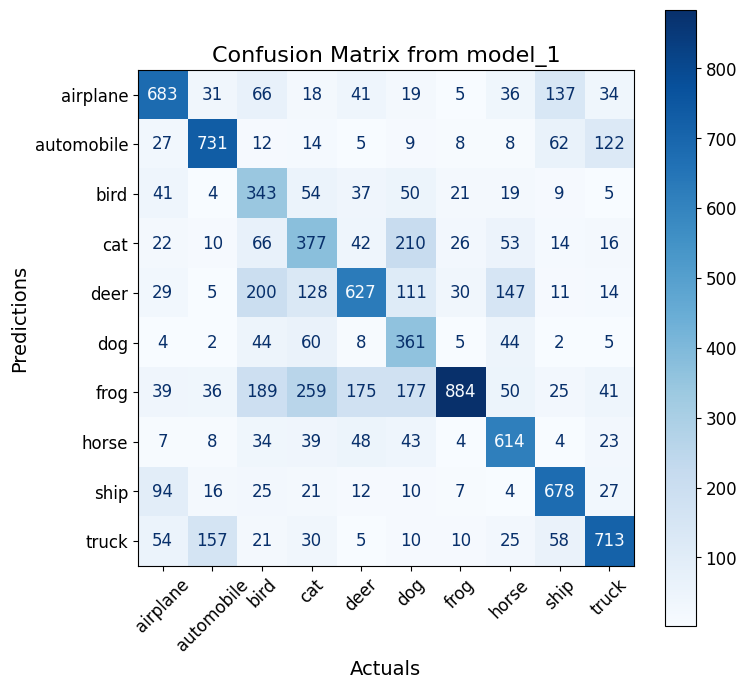

In [16]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [17]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.64      0.68      0.66      1000
  automobile       0.73      0.73      0.73      1000
        bird       0.59      0.34      0.43      1000
         cat       0.45      0.38      0.41      1000
        deer       0.48      0.63      0.54      1000
         dog       0.67      0.36      0.47      1000
        frog       0.47      0.88      0.61      1000
       horse       0.75      0.61      0.67      1000
        ship       0.76      0.68      0.72      1000
       truck       0.66      0.71      0.68      1000

    accuracy                           0.60     10000
   macro avg       0.62      0.60      0.59     10000
weighted avg       0.62      0.60      0.59     10000



$
\begin{align}
Accuracy &= \frac{TP + TN}{TP + TN + FP + FN} \\
Precision &= \frac{TP}{TP + FP} \\
Recall &= \frac{TP}{TP + FN} \\
F1-Score &= \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{align}
$

where 
$TP$: True Positives, $TN$: True Negatives, $FP$: False Positives, and $FN$: False Negatives


### <span style="color:blue">แบบฝึกปฏิบัติ</span>
จากโครงสร้างของโมเดลเดิม:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

1. ให้สร้างโมเดลใหม่ที่มีความซับซ้อนมากขึ้นโดยสามารถใช้รูปแบบโครงสร้างดังนี้:
   - Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

   - ให้ใช้ stride เป็น 1 สำหรับทุกเลเยอร์ convolutional.

2. เทรนโมเดลใหม่โดยใช้เพียง 10 epochs (เท่ากับการเทรนโมเดลเดิม) และอธิบายสิ่งที่สังเกตได้ในเรื่องของเวลา และค่า loss และ accuracy ที่วัดได้จากทั้งชุดข้อมูลเทรนและเทส

3. จากผลการทดสอบโมเดลใหม่ด้วยชุดข้อมูลเทส ให้สร้างกราฟ Confusion Matrix และแสดงรายงาน classification report

4. หาภาพที่โมเดลใหม่ทำนายผิดมาอย่างน้อย 1 ภาพ โดยแสดงภาพให้ปรากฏ แสดงข้อความว่าภาพนั้นเป็นภาพของคลาสอะไร และโมเดลทำนายผิดเป็นคลาสอะไร

### <span style="color:pink">จากแบบฝึกปฏิบัติ</span>

In [18]:
set_seed(12345)

# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        25632     
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                  

Notice: การ complie model ที่ได้ 3 นาทีเกิดจากการใช้ GPU ในการ complie
<p>
แต่ถ้าใช้ CPU ในการ complie จะใช้เวลา 30 นาทีแทน 
(ผู้ train model ใช้งานทำอย่างอื่นด้วย แต่ CPU Usage ถูกใช้ 100% อยู่แล้ว ในกรณีนี้)

In [19]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 25s 14ms/step - loss: 1.6012 - accuracy: 0.4179 - val_loss: 1.4596 - val_accuracy: 0.4783
Epoch 2/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1720 - accuracy: 0.5845 - val_loss: 1.0851 - val_accuracy: 0.6210
Epoch 3/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.9854 - accuracy: 0.6567 - val_loss: 0.9864 - val_accuracy: 0.6522
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.8808 - accuracy: 0.6952 - val_loss: 0.8880 - val_accuracy: 0.6944
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.8160 - accuracy: 0.7208 - val_loss: 0.8944 - val_accuracy: 0.7023
Epoch 6/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.7679 - accuracy: 0.7372 - val_loss: 0.8805 - val_accuracy: 0.7153
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.7282 - accuracy: 0.7510 - val_loss: 0.8634 -

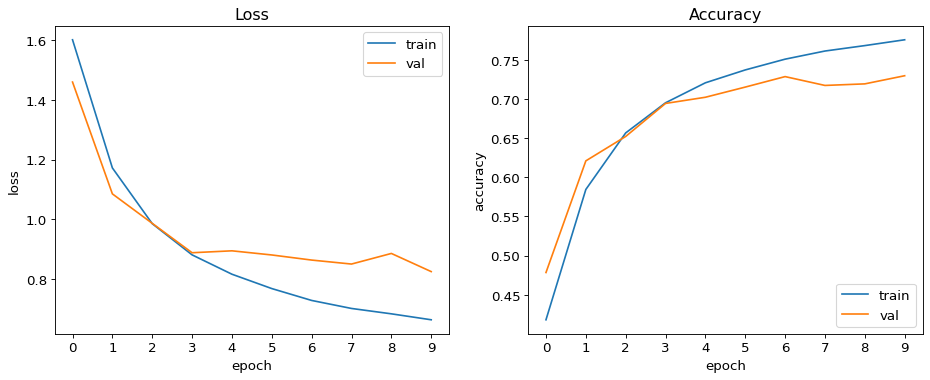

In [20]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

In [21]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 0.598393, Accuracy: 0.805540
 Test Loss: 0.824772, Accuracy: 0.729800

[[747  20  60  20  15  15  12  10 103  30]
 [ 11 827   3   4   0   0   2   0  11  50]
 [ 66   4 586  52  51  40  38  31  13   8]
 [ 28  18  64 569  77 180  63  37  29  19]
 [ 31   2 110  75 729  49  39  66   5   6]
 [  6   3  56 137  26 604  23  37   0   5]
 [  8  13  54  65  33  31 801  10   6   6]
 [ 19   4  51  56  58  71  13 797   9  19]
 [ 42  19  11  10   5   5   5   1 801  20]
 [ 42  90   5  12   6   5   4  11  23 837]]


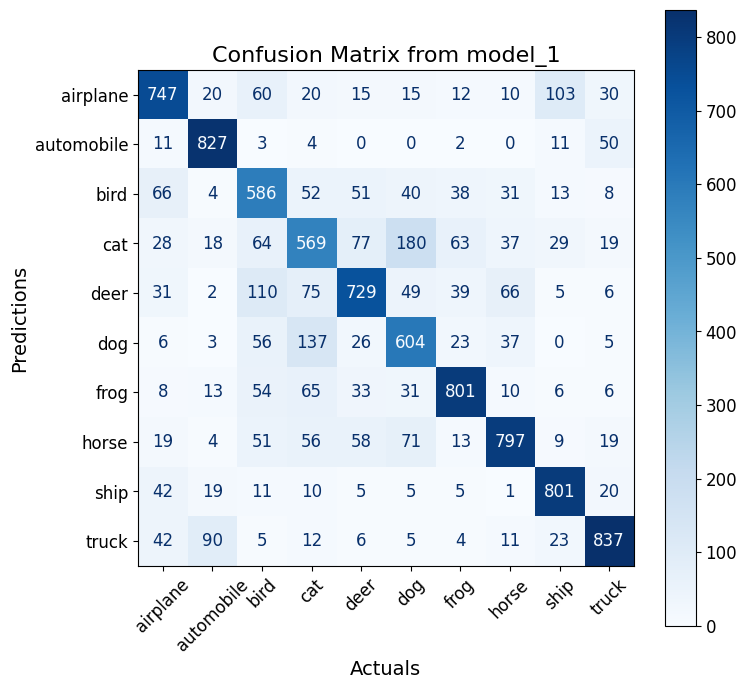

In [22]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [23]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.72      0.75      0.74      1000
  automobile       0.91      0.83      0.87      1000
        bird       0.66      0.59      0.62      1000
         cat       0.52      0.57      0.55      1000
        deer       0.66      0.73      0.69      1000
         dog       0.67      0.60      0.64      1000
        frog       0.78      0.80      0.79      1000
       horse       0.73      0.80      0.76      1000
        ship       0.87      0.80      0.83      1000
       truck       0.81      0.84      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



Image number: 0
Actual label: cat
Predicted label: dog


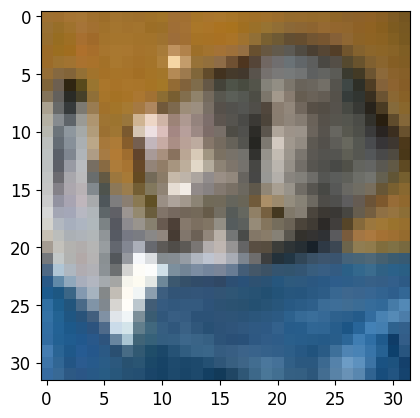

In [24]:
# Show an incorrect prediction image from the test set and tell us what it was supposed to be

incorrect = np.nonzero(y_pred_1d != y_test_1d)[0]
image_no = incorrect[0]
print('Image number:', image_no)
print('Actual label:', class_names[y_test_1d[image_no]])
print('Predicted label:', class_names[y_pred_1d[image_no]])
plt.imshow(x_test[image_no]);

LeNet-5 with RGB color

In [25]:
# Using LeNet-5 Architecture
set_seed(12345)

model_1 = Sequential()

model_1.add(Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(32,32,3)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Flatten())

# model_1.add(Dense(units=400, activation='relu'))

model_1.add(Dense(units=120, activation='relu'))

model_1.add(Dense(units=84, activation='relu'))

model_1.add(Dense(units=10, activation = 'softmax'))

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_4 (Dense)             (None, 120)              

In [26]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 18s 10ms/step - loss: 1.7266 - accuracy: 0.3717 - val_loss: 1.5819 - val_accuracy: 0.4206
Epoch 2/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.4735 - accuracy: 0.4679 - val_loss: 1.5516 - val_accuracy: 0.4450
Epoch 3/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.3674 - accuracy: 0.5075 - val_loss: 1.3552 - val_accuracy: 0.5091
Epoch 4/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.2906 - accuracy: 0.5374 - val_loss: 1.3696 - val_accuracy: 0.5066
Epoch 5/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.2303 - accuracy: 0.5601 - val_loss: 1.2732 - val_accuracy: 0.5413
Epoch 6/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.1793 - accuracy: 0.5809 - val_loss: 1.2678 - val_accuracy: 0.5514
Epoch 7/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.1342 - accuracy: 0.6004 - val_loss: 1.3276 -

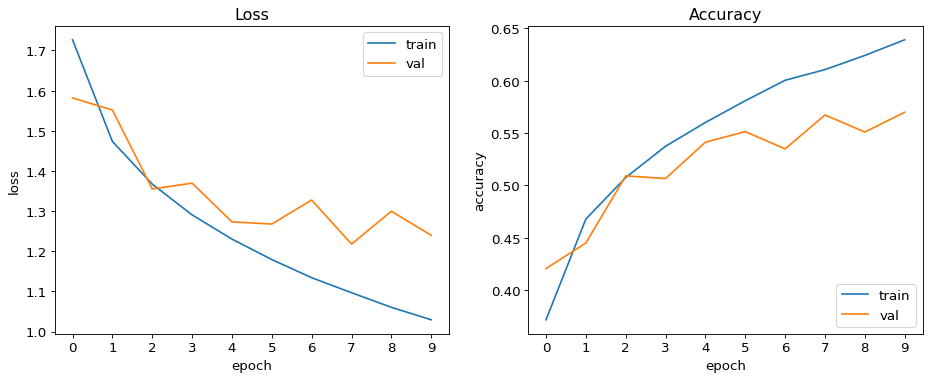

In [27]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

In [28]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 1.064944, Accuracy: 0.621740
 Test Loss: 1.239701, Accuracy: 0.569900

[[601  22  50  13  13   1   3   9 116  22]
 [ 43 701  16  24   7   4   8   8  87 116]
 [ 32   4 286  38  37  43  19  14  12   6]
 [ 13   8  59 323  34 190  30  43  15  11]
 [ 55   7 201 123 547 110  29  98  19  12]
 [  9   3  66 137  26 387  12  51   5  10]
 [ 59  25 207 242 214 150 870  55  30  50]
 [ 32  15  65  58  95  93  15 698  14  40]
 [ 76  18  17  10  12   9   4   0 576  23]
 [ 80 197  33  32  15  13  10  24 126 710]]


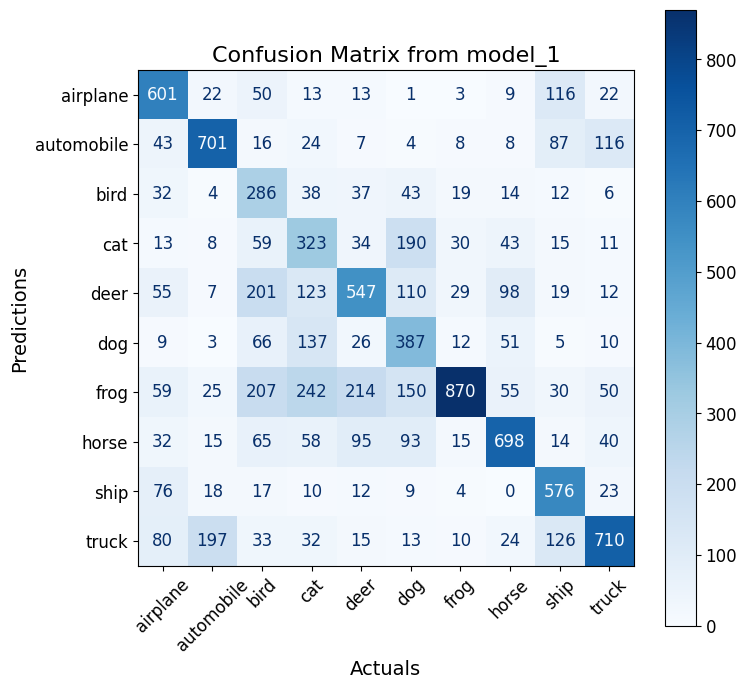

In [29]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [30]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.71      0.60      0.65      1000
  automobile       0.69      0.70      0.70      1000
        bird       0.58      0.29      0.38      1000
         cat       0.44      0.32      0.37      1000
        deer       0.46      0.55      0.50      1000
         dog       0.55      0.39      0.45      1000
        frog       0.46      0.87      0.60      1000
       horse       0.62      0.70      0.66      1000
        ship       0.77      0.58      0.66      1000
       truck       0.57      0.71      0.63      1000

    accuracy                           0.57     10000
   macro avg       0.59      0.57      0.56     10000
weighted avg       0.59      0.57      0.56     10000



Image number: 1
Actual label: ship
Predicted label: automobile


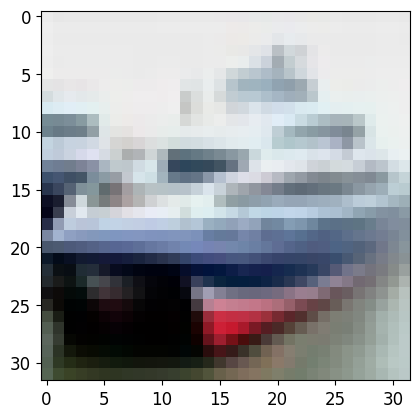

In [31]:
# Show an incorrect prediction image from the test set and tell us what it was supposed to be

incorrect = np.nonzero(y_pred_1d != y_test_1d)[0]
image_no = incorrect[0]
print('Image number:', image_no)
print('Actual label:', class_names[y_test_1d[image_no]])
print('Predicted label:', class_names[y_pred_1d[image_no]])
plt.imshow(x_test[image_no]);